# **ESERCITAZIONE DI IDROLOGIA**

<figure>
    <img src="Figures/logo uni.png" width="100" height="100/1.618">
<figure>
    
    UNIVERSITÀ DEGLI STUDI DI TRENTO
    DIPARTIMENTO DI INGEGNERIA CIVILE, AMBIENTALE E MECCANICA
    A.A. 2022-2023
      
    
*Alunni:*  
Del Dò Giacomo, 221545       
Faccin Francesca, 222028       
Rossato Sofia, 218790 

# **Notebook 2: Metodi di Determinazione dei Parametri di Gumbel**

# Metodo dei Momenti

Il metodo dei momenti consente di determinare i parametri della curva di Gumbel eguagliando i momenti del campione con i momenti della popolazione. Risolvendo quindi un numero di equazioni pari al numero di parametri da stimare si ottengono i valori stimati dei parametri "a" e "b". 

Si richiama l'espressione della curva di Gumebl:
$$P[H<h; a,b] = e^{-e-{\frac{h-a}{b}}}$$


Nel caso in cui si usi il metodo dei momenti per stimare i parametri della curva di Gumbel si dovranno uguagliare la media e la varianza del campione con la media e la varianza della popolazione. 
Il metodo dei momenti si riduce quindi alla risoluzione del sistema:
$$\begin{equation}
\left\{
\begin{array}{l}
b \gamma + a = \mu_H \\
\sigma^2_H = b^2  \frac{\pi^2}{6}
\end{array}
\right.
\end{equation}$$
dove $a$ e $b$ sono i parametri da stimare, $mu_H$ è la media del campioni di dati, e $\sigma_H$ è la deviazione standard dei medesimi dati e $\gamma = 0.572$ è il numero irrazionale detto di Eulero-Mascheroni.

Dal quale si ricavano i parametri:
$$\begin{equation}
b = \frac{\sqrt{6}}{\pi} \sigma_H
\end{equation}$$

$$\begin{equation}
a = \mu_H -\frac{\sqrt{6}\gamma}{\pi} \sigma_H 
\end{equation}$$

In [1]:
import os
import math
from pandas import *
import numpy as np
import pandas as pd
from datetime import datetime
%matplotlib inline 
import matplotlib.pyplot as plt
import plotly.express as px

os.getcwd()
os.chdir("/Users/francescafaccin/Desktop/idrologia/Installations05122022/class2023/1_ESERCITAZIONE")
data = pd.read_csv('PluviometriaValdagno.txt')
map(datetime,data['Anno'])
data = data.set_index('Anno')

Text(0, 0.5, 'Media')

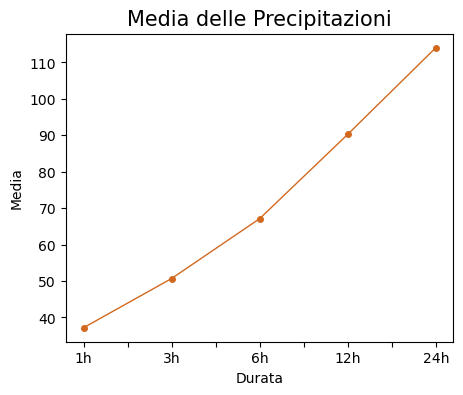

In [2]:
means = data.mean() 
means

ax = means.plot(style="o-", markersize=4, linewidth=1.0, color="chocolate", figsize=(5,4))
#ax.grid(True)
ax.set_title("Media delle Precipitazioni", fontsize=15)
ax.set_xlabel("Durata", fontsize=10)
ax.set_ylabel("Media", fontsize=10)

Text(0, 0.5, 'Varianza')

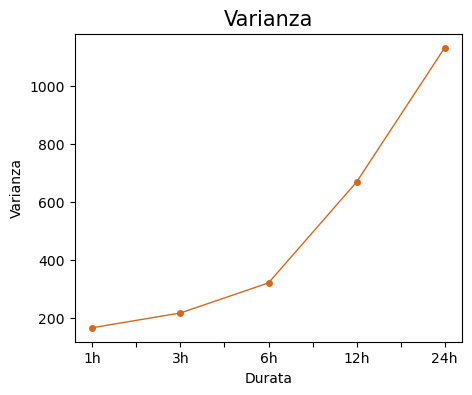

In [3]:
variances = data.var() 
variances

ax = variances.plot(style="o-", markersize=4, linewidth=1.0, color="chocolate", figsize=(5,4))
#ax.grid(True)
ax.set_title("Varianza", fontsize=15)
ax.set_xlabel("Durata", fontsize=10)
ax.set_ylabel("Varianza", fontsize=10)

Text(0, 0.5, 'cv')

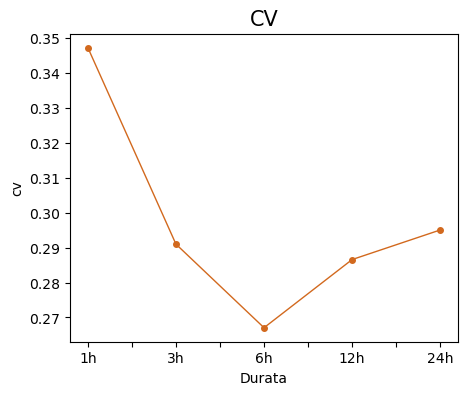

In [4]:
stds = data.std() 
stds

cv = data.std()/means 
cv

ax = cv.plot(style="o-", markersize=4, linewidth=1.0, color="chocolate", figsize=(5,4))
#ax.grid(True)
ax.set_title("CV", fontsize=15)
ax.set_xlabel("Durata", fontsize=10)
ax.set_ylabel("cv", fontsize=10)

In [5]:
uno = np.sqrt(6)/np.pi #definisco la funzione gino per poter calcolare il parametro b
EulerGamma=0.577215664901532860606512090
due = uno*EulerGamma

def g(m,s):
    return pd.DataFrame([means-due*stds,uno*stds], index=["a","b"])

abs_m = g(means,stds)
abs_m.to_pickle("abs_m")
abs_m

In [6]:
from scipy.stats import genextreme,gumbel_r
from numpy import linspace
from statsmodels.distributions.empirical_distribution import ECDF

def gumbel(x,abs_d,col):
    return np.exp(-np.exp(-(x-abs_d[col]["a"])/abs_d[col]["b"])) 

t_rain = np.linspace(data.min()["1h"], data.max()["24h"], 100)

gb = pd.DataFrame([gumbel(t_rain,abs_m, "1h"),
                   gumbel(t_rain,abs_m, "3h"),
                   gumbel(t_rain,abs_m, "6h"),
                   gumbel(t_rain,abs_m, "12h"),
                   gumbel(t_rain,abs_m, "24h")]).T
gb.index = t_rain
gb.columns = ["1h","3h","6h","12h","24h"]

Text(0, 0.5, 'P[H<h]')

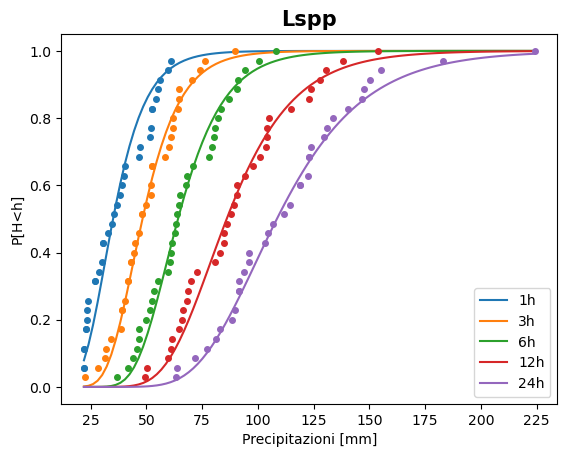

In [7]:
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10) 
ax = gb.plot(color=["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple"])

ecdf1h = ECDF(data["1h"])
ax.plot(data["1h"], ecdf1h(data["1h"]), "o", markersize=4, c="tab:blue")

data3h = data["3h"]
ecdf3h = ECDF(data3h)
ax.plot(data3h, ecdf3h(data3h), "o", markersize=4, c="tab:orange", label="3h")

data6h = data["6h"]
ecdf6h = ECDF(data6h)
ax.plot(data6h, ecdf6h(data6h), "o", markersize=4, c="tab:green", label="6h")

data12h = data["12h"]
ecdf12h = ECDF(data12h)
ax.plot(data12h, ecdf12h(data12h), "o", markersize=4, c="tab:red", label="12h")

data24h = data["24h"]
ecdf24h = ECDF(data24h)
ax.plot(data24h, ecdf24h(data24h), "o", markersize=4, c="tab:purple", label="24h")

ax.set_title("Lspp", fontsize=15, fontweight="bold") 
ax.set_xlabel("Precipitazioni [mm]", fontsize=10)
ax.set_ylabel("P[H<h]", fontsize=10)

# Metodo della Massima Verosimiglianza

Il metodo della massima verosimiglianza calcola i valori dei parametri per cui  la probabilità congiunta di ottenere una serie di dati $\{h_1, \cdot \cdot, h_n \}$ è massima:

\begin{equation}
{\rm argmax}_{a,b} P[\{h_1, \cdot \cdot, h_n \};a,b] = {\rm argmax}_{a,b} \prod_i^n P[h_i;a,b]
\end{equation}

In [8]:
samp = data["1h"].dropna()
param1h = gumbel_r.fit(samp)

samp = data["3h"]
param3h = gumbel_r.fit(samp)

samp = data["6h"]
param6h = gumbel_r.fit(samp)

samp = data["12h"]
param12h = gumbel_r.fit(samp)

samp = data["24h"]
param24h = gumbel_r.fit(samp)

In [9]:
abs_mle = pd.DataFrame([param1h, param3h, param6h, param12h, param24h],
                       columns=["a","b"],
                       index=["1h","3h","6h","12h","24h"]).T

abs_mle.to_pickle("abs_mle")
abs_mle

In [10]:
import numpy as np
from statsmodels.distributions.empirical_distribution import ECDF
def gumbel(x,abs_d,col):
    return np.exp(-np.exp(-(x-abs_d[col]["a"])/abs_d[col]["b"]))

t_rain = np.linspace(data.min()["1h"], data.max()["24h"], 100)

gb = pd.DataFrame([gumbel(t_rain,abs_mle,"1h"),
                   gumbel(t_rain,abs_mle,"3h"),
                   gumbel(t_rain,abs_mle,"6h"),
                   gumbel(t_rain,abs_mle,"12h"),
                   gumbel(t_rain,abs_mle,"24h")]).T
gb.index = t_rain
gb.columns = ["1h","3h","6h","12h","24h"]
gb[5:]

Text(0, 0.5, 'P[H<h]')

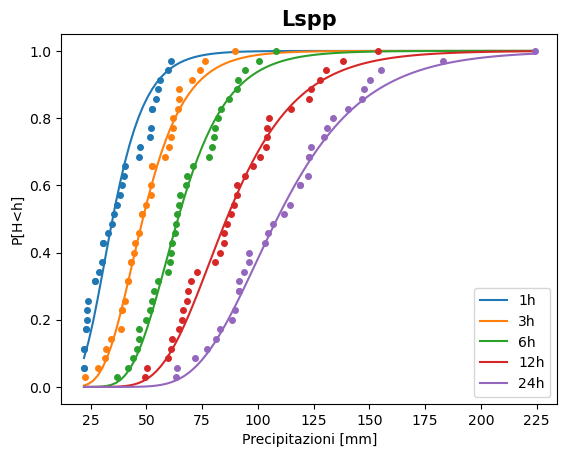

In [11]:
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
ax = gb.plot(color=["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple"])

ecdf1h = ECDF(data["1h"])
ax.plot(data["1h"], ecdf1h(data["1h"]), "o", markersize=4, c="tab:blue", label="1h")

data3h = data["3h"]
ecdf3h = ECDF(data3h)
ax.plot(data3h, ecdf3h(data3h), "o", markersize=4, c="tab:orange", label="3h")

data6h = data["6h"]
ecdf6h = ECDF(data6h)
ax.plot(data6h, ecdf6h(data6h), "o", markersize=4, c="tab:green", label="6h")

data12h = data["12h"]
ecdf12h = ECDF(data12h)
ax.plot(data12h, ecdf12h(data12h), "o", markersize=4, c="tab:red", label="12h")

data24h = data["24h"]
ecdf24h = ECDF(data24h)
ax.plot(data24h, ecdf24h(data24h), "o", markersize=4, c="tab:purple", label="24h")

ax.set_title("Lspp", fontsize=15, fontweight="bold")
ax.set_xlabel("Precipitazioni [mm]", fontsize=10)
ax.set_ylabel("P[H<h]", fontsize=10)

# Metodo dei Minimi Quadrati

Mediante il metodo dei minimi quadrati si ricava la funzione che minimizza la somma dei quadrati delle distanze tra i dati osservati e quelli della curva che rappresenta la funzione stessa.

Sia ϵi l'errore di misura (osservazione), con il metodo dei minimi quadrati si cerca xx come soluzione al seguente problema di ottimizzazione:

\begin{equation}
{δ2(a,b)=∑iN(ECDFi−P[hi;a,b])2→min}
\end{equation}

In [12]:
from scipy.stats import norm
from pylab import plot,show,hist,figure,title
from scipy.optimize import least_squares

def fun(x,t,y):
    return np.exp(-np.exp(-(t-x[0])/x[1]))-y

In [13]:
abs_m = pd.read_pickle('abs_m')
abs_m.head()

# per le 1h
ecdf1h = ECDF(data["1h"])

x0 = [abs_m.iloc[0,0], abs_m.iloc[1,0]]

t_train = sorted(data["1h"].dropna())
y_train = ecdf1h(t_train)

res_lsq_1h = least_squares(fun, x0, args=(t_train, y_train))


#per le 3h
ecdf3h = ECDF(data["3h"])

x0 = [abs_m.iloc[0,1], abs_m.iloc[1,1]]

t_train = sorted(data["3h"].dropna())
y_train = ecdf3h(t_train)

res_lsq_3h = least_squares(fun, x0, args=(t_train, y_train))


#per le 6h
ecdf6h = ECDF(data["6h"])

x0 = [abs_m.iloc[0,2], abs_m.iloc[1,2]]

t_train = sorted(data["6h"].dropna())
y_train = ecdf6h(t_train)

res_lsq_6h = least_squares(fun, x0, args=(t_train, y_train))


#per le 12h
ecdf12h = ECDF(data["12h"])

x0 = [abs_m.iloc[0,3], abs_m.iloc[1,3]]

t_train = sorted(data["12h"].dropna())
y_train = ecdf12h(t_train)

res_lsq_12h = least_squares(fun, x0, args=(t_train, y_train))


#per le 24h
ecdf24h = ECDF(data["24h"])

x0 = [abs_m.iloc[0,4],abs_m.iloc[1,4]]

t_train = sorted(data["24h"].dropna())
y_train = ecdf24h(t_train)

res_lsq_24h = least_squares(fun, x0, args=(t_train, y_train))

In [14]:
abs_mq = pd.DataFrame([res_lsq_1h.x, res_lsq_3h.x, res_lsq_6h.x, res_lsq_12h.x, res_lsq_24h.x],
                      columns=["a","b"],
                      index=["1h","3h","6h","12h","24h"]).T
abs_mq.to_pickle("abs_mq")
abs_mq

In [15]:
def gumbel(x, abs_d, col):
    return np.exp(-np.exp(-(x-abs_d[col]["a"])/abs_d[col]["b"]))
t_rain = np.linspace(data.min()[0], data.max()[4], 100)

In [16]:
gb = pd.DataFrame([gumbel(t_rain,abs_mq,"1h"),
                   gumbel(t_rain,abs_mq,"3h"),
                   gumbel(t_rain,abs_mq,"6h"),
                   gumbel(t_rain,abs_mq,"12h"),
                   gumbel(t_rain,abs_mq,"24h")]).T
gb.index = t_rain
gb.columns = ["1h","3h","6h","12h","24h"]

Text(0, 0.5, 'P[H<h]')

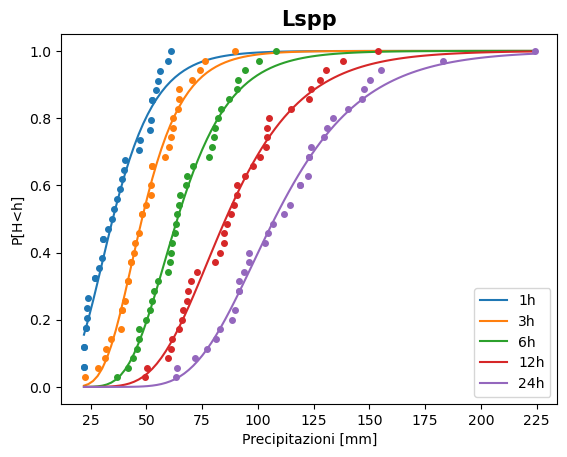

In [17]:
plt.rc('xtick', labelsize=10) 
plt.rc('ytick', labelsize=10) 
ax = gb.plot(color=["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple"])

data1h = data["1h"].dropna()
ecdf1h = ECDF(data1h)
ax.plot(data["1h"], ecdf1h(data["1h"]), "o", markersize=4, c="tab:blue", label="1h")

data3h = data["3h"]
ecdf3h = ECDF(data3h)
ax.plot(data3h, ecdf3h(data3h), "o", markersize=4, c="tab:orange", label="3h")

data6h = data["6h"]
ecdf6h = ECDF(data6h)
ax.plot(data6h,ecdf6h(data6h), "o", markersize=4, c="tab:green", label="6h")

data12h = data["12h"]
ecdf12h = ECDF(data12h)
ax.plot(data12h, ecdf12h(data12h), "o", markersize=4, c="tab:red", label="12h")

data24h = data["24h"]
ecdf24h = ECDF(data24h)
ax.plot(data24h, ecdf24h(data24h), "o", markersize=4, c="tab:purple", label="24h")

ax.set_title("Lspp", fontsize=15, fontweight="bold")
ax.set_xlabel("Precipitazioni [mm]", fontsize=10)
ax.set_ylabel("P[H<h]", fontsize=10)